In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from functools import partial
from pathlib import Path
from datetime import datetime
import math

from core.multimodal.dataset import collate_fn, ASASSNVarStarDataset
from core.multimodal.dataset2 import VGDataset
from models.Informer import Informer

In [6]:
CLASSES = ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW',
           'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']

In [7]:
def get_config(random_seed):

    config = {
        'project': 'vband-classification',
        'random_seed': random_seed,
        'use_wandb': True,
        'save_weights': True,
        'weights_path': f'/home/mariia/AstroML/weights/{datetime.now().strftime("%Y-%m-%d-%H-%M")}',
        'use_pretrain': None,
        
        # Data
        'dataset_class': 'VGDataset',   # 'VGDataset' or 'ASASSNVarStarDataset'
        'data_root': '/home/mariia/AstroML/data/asassn',
        'vg_file': 'v.csv',     # 'vg_combined.csv', 'v.csv', 'g.csv'
        'scales': 'mean-mad',    # 'scales.json', 'mean-std', 'mean-mad'
        'seq_len': 1500,
        'min_samples': None,
        'max_samples': 20000,
        'classes': CLASSES,
        'phased': True,
        'periodic': True,
        'clip_outliers': False,
        'aux': True,

        # Model
        'model': 'informer',  # 'informer' or 'vanilla'
        'encoder_layers': 2,
        'd_model': 128,
        'dropout': 0.2,
        'feature_size': 3,

        # Informer
        'n_heads': 4,
        'd_ff': 512,

        # Time Series Transformer
        'prediction_length': 20,    # doesn't matter for classification, but it's required by hf
        'num_time_features': 1,
        'num_static_real_features': 0,  # if 0 we don't use real features
        'distribution_output': 'normal',
        'scaling': None,
        'encoder_layerdrop': 0,
        'attention_dropout': 0,
        'activation_dropout': 0,

        # Training
        'batch_size': 32,
        'lr': 1e-3,
        'weight_decay': 0.01,
        'epochs': 50,
        'optimizer': 'AdamW',   # 'AdamW', 'RAdam'

        # Learning Rate Scheduler
        'factor': 0.3,
        'patience': 10,
    }

    if config['aux']:
        config['feature_size'] += 3     # + (mean, std, period)

    return config

In [8]:
config = get_config(42)

In [9]:
train_dataset = VGDataset(
    config['data_root'], config['vg_file'], split='train', seq_len=config['seq_len'],
    min_samples=config['min_samples'], max_samples=config['max_samples'], phased=config['phased'],
    periodic=config['periodic'], classes=config['classes'], clip=config['clip_outliers'],
    random_seed=config['random_seed'], scales=config['scales'], aux=config['aux']
)

Leaving only classes: ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']... 446934 objects left.
Removing objects without periods... 446900 objects left.
Removing objects that have more than 20000 or less than None samples... 154029 objects left.
train split is selected: 123223 objects left.


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

In [11]:
model = Informer(enc_in=config['feature_size'], d_model=config['d_model'], dropout=config['dropout'], factor=1,
                 output_attention=False, n_heads=config['n_heads'], d_ff=config['d_ff'],
                 activation='gelu', e_layers=config['encoder_layers'], seq_len=config['seq_len'],
                 num_class=train_dataset.num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()

In [85]:
for i in tqdm(range(len(train_dataset))):
    X = train_dataset.get_vlc(train_dataset.df.iloc[i]['name'])
    mean = X[:, 1].mean()
    std = stats.median_abs_deviation(X[:, 1])
    period = train_dataset.df.iloc[i]['period']

    if mean < 0.001:
        print(i, mean)

  0%|                                                                           | 135/123223 [00:00<05:47, 353.71it/s]

85 -1.965591836734694


  0%|▎                                                                          | 511/123223 [00:01<05:23, 379.43it/s]

442 -0.008582089552238803


  1%|▌                                                                          | 851/123223 [00:02<04:57, 411.59it/s]

782 -3.017931914893617


  1%|▌                                                                          | 893/123223 [00:02<06:00, 339.57it/s]

869 -1.01856346749226


  1%|▌                                                                         | 1019/123223 [00:02<05:17, 385.08it/s]

939 -0.5685612052730697


  1%|▋                                                                         | 1092/123223 [00:03<05:46, 352.92it/s]


KeyboardInterrupt: 

In [84]:
type(mean)

numpy.float64

In [13]:
losses = []

for X, mask, y in tqdm(train_dataloader):
    X, mask, y = X.to(device), mask.to(device), y.to(device)
    out = model(X, mask)
    loss = criterion(out, y)

    if torch.isnan(loss):
        break
        
    losses.append(loss.item())

  2%|█▋                                                                             | 82/3851 [00:14<11:19,  5.55it/s]


KeyboardInterrupt: 

In [83]:
out[21], X[21]

(tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([[ 0.0000e+00,  3.3488e+01,  6.8571e-01,         nan, -1.4065e+00,
           3.7442e+00],
         [ 2.0450e-04,  3.3802e+01,  6.8980e-01,         nan, -1.4065e+00,
           3.7442e+00],
         [ 4.8803e-04,  3.3655e+01,  6.8571e-01,         nan, -1.4065e+00,
           3.7442e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,         nan, -1.4065e+00,
           3.7442e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,         nan, -1.4065e+00,
           3.7442e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,         nan, -1.4065e+00,
           3.7442e+00]], device='cuda:0'))

In [62]:
X, mask, y = next(iter(train_dataloader))
X, mask, y = next(iter(train_dataloader))
X, mask, y = next(iter(train_dataloader))

In [64]:
X, mask, y = X.to(device), mask.to(device), y.to(device)
out = model(X, mask)
loss = criterion(out, y)

In [75]:
math.isnan(losses[3])

False

In [14]:
CLASSES = ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW',
           'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']
train_dataset = VGDataset('/home/mariia/AstroML/data/asassn', 'v.csv', split='train', seq_len=200, scales='mean-mad', classes=CLASSES, max_samples=20000, aux=True)

Removing objects that have more than 20000 or less than None samples... 232045 objects left.
train split is selected: 185636 objects left.


In [16]:
i = 0
train_dataset.df.iloc[i]['period'], train_dataset[i]

(nan,
 (array([[ 0.0000000e+00, -6.2492287e-01,  5.6543982e-01,  5.2469525e+00,
           1.8015448e+00,  0.0000000e+00],
         [ 6.9077872e-04, -1.7105259e-01,  5.7385707e-01,  5.2469525e+00,
           1.8015448e+00,  0.0000000e+00],
         [ 1.3037306e-03, -2.4482714e-01,  5.7237166e-01,  5.2469525e+00,
           1.8015448e+00,  0.0000000e+00],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  5.2469525e+00,
           1.8015448e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  5.2469525e+00,
           1.8015448e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  5.2469525e+00,
           1.8015448e+00,  0.0000000e+00]], dtype=float32),
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1

In [15]:
train_dataset.df['period']

0                NaN
1         157.016334
2           0.397274
3           0.257873
5           0.465090
             ...    
232038    112.826982
232039    181.463454
232040    192.663845
232041      2.842057
232043      3.828959
Name: period, Length: 185636, dtype: float64

In [24]:
for _ in range(10):
    i = random.randint(0, len(train_dataset))
    X = train_dataset.get_vlc(train_dataset.df.iloc[i]['name'])
    period = train_dataset.df.iloc[i]['period']
    
    mean = X[:, 1].mean()
    std = stats.median_abs_deviation(X[:, 1])
    print(round(mean, 2), round(std, 2), round(np.log(mean), 2), round(np.log(std), 2))

3.7 0.2 1.31 -1.62
2.55 0.91 0.93 -0.1
2.65 0.16 0.98 -1.83
4.25 0.38 1.45 -0.97
2.81 0.28 1.03 -1.29
11.49 0.44 2.44 -0.82
8.15 0.17 2.1 -1.75
13.24 0.38 2.58 -0.98
2.0 0.15 0.69 -1.89
36.14 0.94 3.59 -0.06


In [39]:
df = pd.read_csv('/home/mariia/AstroML/data/asassn/v.csv')

In [49]:
pd.isna(df.iloc[3]['period'])

True

In [25]:
log_mean = np.log(mean)
log_std = np.log(std)
log_period = np.log(period)

In [26]:
log_mean, log_std, log_period

(3.587434566204956, -0.05868899634868185, 1.2996864390949963)

In [34]:
X.shape

(113, 3)

In [35]:
aux = np.tile([log_mean, log_std, log_period], (X.shape[0], 1))
aux.shape

(113, 3)

In [37]:
features = np.concatenate((X, aux), axis=-1)
features.shape

(113, 6)

In [38]:
features

array([[ 2.45802196e+06,  3.68160000e+01,  6.77000000e-01,
         3.58743457e+00, -5.86889963e-02,  1.29968644e+00],
       [ 2.45733377e+06,  3.27640000e+01,  6.03000000e-01,
         3.58743457e+00, -5.86889963e-02,  1.29968644e+00],
       [ 2.45724600e+06,  3.38270000e+01,  6.22000000e-01,
         3.58743457e+00, -5.86889963e-02,  1.29968644e+00],
       [ 2.45721307e+06,  3.34940000e+01,  6.16000000e-01,
         3.58743457e+00, -5.86889963e-02,  1.29968644e+00],
       [ 2.45768685e+06,  3.70650000e+01,  6.82000000e-01,
         3.58743457e+00, -5.86889963e-02,  1.29968644e+00],
       [ 2.45807183e+06,  3.62900000e+01,  6.68000000e-01,
         3.58743457e+00, -5.86889963e-02,  1.29968644e+00],
       [ 2.45766971e+06,  3.72270000e+01,  6.85000000e-01,
         3.58743457e+00, -5.86889963e-02,  1.29968644e+00],
       [ 2.45830807e+06,  3.84640000e+01,  7.08000000e-01,
         3.58743457e+00, -5.86889963e-02,  1.29968644e+00],
       [ 2.45789507e+06,  3.55030000e+01,  6.530

In [4]:
g_data = VGDataset('/home/mariia/AstroML/data/asassn', 'g.csv', split='all')

Split is not train, val, or test. Keeping the whole dataset
all split is selected: 378823 objects left.


In [7]:
g_data.df['target'].value_counts().sort_index()

target
CWA         153
CWB          74
DCEP        434
DCEPS       112
DSCT       2395
EA        21927
EB        13371
EW        47570
HADS       2231
L         13937
M          6649
ROT       53169
RRAB      19035
RRC        6968
RRD         512
RVA           3
SR       189368
VAR         559
YSO         356
Name: count, dtype: int64

In [ ]:
CEPH, DSCT, ECL, LPV, RRAB, RRc/RRd, ROT

In [ ]:
DSCT

In [299]:
def preprocess_batch(batch, masks):
    context_length = 200
    lcs, classes = batch
    lcs_mask, classes_mask = masks

    # shape now [128, 1, 3, 759], make [128, 3, 759]
    X = lcs[:, 0, :, :]

    # change axises, shape now [128, 3, 759], make [128, 759, 3]
    X = X.transpose(1, 2)

    # since mask is the same for time flux and flux err we can make it 2D
    mask = lcs_mask[:, 0, 0, :]

    # context length 200, crop X and MASK if longer, pad if shorter
    if X.shape[1] < context_length:
        X_padding = (0, 0, 0, context_length - X.shape[1], 0, 0)
        mask_padding = (0, context_length - X.shape[1])
        X = F.pad(X, X_padding)
        mask = F.pad(mask, mask_padding, value=True)
    else:
        X = X[:, :context_length, :]
        mask = mask[:, :context_length]

    # the last dimension is (time, flux, flux_err), sort it based on time
    sort_indices = torch.argsort(X[:, :, 0], dim=1)
    sorted_X = torch.zeros_like(X)

    for i in range(X.shape[0]):
        sorted_X[i] = X[i, sort_indices[i]]

    # rearange indexes for masks as well
    sorted_mask = torch.zeros_like(mask)

    for i in range(mask.shape[0]):
        sorted_mask[i] = mask[i, sort_indices[i]]

    # mask should be 1 for values that are observed and 0 for values that are missing
    sorted_mask = 1 - sorted_mask.int()

    # read scales
    with open(os.path.join(data_root, 'scales.json'), 'r') as f:
        scales = json.load(f)
        mean, std = scales['v']['mean'], scales['v']['std']

    # scale X
    sorted_X[:, :, 1] = (sorted_X[:, :, 1] - mean) / std
    sorted_X[:, :, 2] = sorted_X[:, :, 2] / std

    # reshape classes to be 1D vector and convert from float to int
    classes = classes[:, 0]
    classes = classes.long()

    return sorted_X, sorted_mask, classes

In [351]:
import json
import os
from io import BytesIO
import tarfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from filelock import FileLock
from torch.utils.data import Dataset

from util.parallelzipfile import ParallelZipFile as ZipFile
from util.preprocess_data import clip_outliers


class VGDataset(Dataset):
    def __init__(self, data_root, vg_file, v_zip='asassnvarlc_vband_complete.zip', g_tar='g_band_lcs-001.tar',
                 v_prefix='vardb_files', g_prefix='g_band_lcs', scales_file='scales.json',
                 seq_len=200, split='train', min_samples=None, max_samples=None, classes=None, random_seed=42,
                 phased=True, periodic=True, clip_outliers=True, verbose=True):
        self.data_root = data_root
        self.df = pd.read_csv(os.path.join(data_root, f'{vg_file}_{split}.csv'))
        self.reader_v = ZipFile(os.path.join(data_root, v_zip))

        self.v_prefix = v_prefix
        self.g_prefix = g_prefix

        with open(os.path.join(data_root, scales_file)) as f:
            self.scales = json.load(f)

        self.seq_len = seq_len
        # self.split = split
        self.min_samples = min_samples
        self.max_samples = max_samples
        self.classes = classes
        self.phased = phased
        self.periodic = periodic
        self.clip_outliers = clip_outliers
        self.verbose = verbose

        self.random_seed = random_seed
        np.random.seed(random_seed)

        self._filter_classes()
        self._filter_periodic()
        self._limit_samples()
        # self._split()
        
        self.id2target = {i: x for i, x in enumerate(sorted(self.df['target'].unique()))}
        self.target2id = {v: k for k, v in self.id2target.items()}
        self.num_classes = len(self.id2target)


    # def _split(self):
    #     unique_ids = self.df['id'].unique()
    #     train_ids, temp_ids = train_test_split(unique_ids, test_size=0.2, random_state=self.random_seed)
    #     val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=self.random_seed)

    #     if self.split == 'train':
    #         self.df = self.df[self.df['id'].isin(train_ids)]
    #     elif self.split == 'val':
    #         self.df = self.df[self.df['id'].isin(val_ids)]
    #     elif self.split == 'test':
    #         self.df = self.df[self.df['id'].isin(test_ids)]
    #     else:
    #         print('Split is not train, val, or test. Keeping the whole dataset')

    #     if self.verbose:
    #         print(f'{self.split} split is selected: {len(self.df)} objects left.')            

    def _filter_classes(self):
        if self.classes:
            if self.verbose:
                print(f'Leaving only classes: {self.classes}... ', end='')

            self.df = self.df[self.df['target'].isin(self.classes)]

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def _filter_periodic(self):
        if self.periodic:
            if self.verbose:
                print(f'Removing objects without periods... ', end='')

            self.df = self.df[~self.df['period'].isna()]

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def _limit_samples(self):
        if self.max_samples or self.min_samples:
            if self.verbose:
                print(
                    f'Removing objects that have more than {self.max_samples} or less than {self.min_samples} samples... ',
                    end='')

            value_counts = self.df['target'].value_counts()

            if self.min_samples:
                classes_to_remove = value_counts[value_counts < self.min_samples].index
                self.df = self.df[~self.df['target'].isin(classes_to_remove)]

            if self.max_samples:
                classes_to_limit = value_counts[value_counts > self.max_samples].index
                for class_type in classes_to_limit:
                    class_indices = self.df[self.df['target'] == class_type].index
                    indices_to_keep = np.random.choice(class_indices, size=self.max_samples, replace=False)
                    self.df = self.df.drop(index=set(class_indices) - set(indices_to_keep))

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def get_vlc(self, file_name):
        csv = BytesIO()
        data_path = f'{self.v_prefix}/{file_name}.dat'

        csv.write(self.reader_v.read(data_path))
        csv.seek(0)

        lc = pd.read_csv(csv, sep='\s+', skiprows=2, names=['HJD', 'MAG', 'MAG_ERR', 'FLUX', 'FLUX_ERR'],
                         dtype={'HJD': float, 'MAG': float, 'MAG_ERR': float, 'FLUX': float, 'FLUX_ERR': float})

        return lc[['HJD', 'FLUX', 'FLUX_ERR']].values

    def get_glc(self, file_name):
        lc = pd.read_csv(os.path.join(self.data_root, self.g_prefix, f'{file_name}.dat'), sep='\s+', skiprows=2,
                         names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'],
                         dtype={'HJD': float, 'camera': 'object', 'mag': 'object', 'mag_err': 'object',
                                'flux': float, 'flux_err': float, 'FWHM': 'object', 'IMAGE': 'object'})

        return lc[['HJD', 'flux', 'flux_err']].values

    def preprocess(self, X, period, band):
        # 3 clip outliers
        t, y, y_err = X[:, 0], X[:, 1], X[:, 2]
        if self.clip_outliers and len(t) > 20:
            t, y, y_err, _, _, _, _, _ = clip_outliers(t, y, y_err, measurements_in_flux_units=True,
                                                       initial_clip=(20, 5), clean_only=True)
        X = np.vstack((t, y, y_err)).T
        
        # 1 phase
        if self.phased:
            X = np.vstack(((X[:, 0] % period) / period, X[:, 1], X[:, 2])).T

        # 5 trim/pad and create mask
        mask = np.ones(self.seq_len)

        if X.shape[0] > self.seq_len:
            X = X[:self.seq_len, :]
        else:
            mask[X.shape[0]:] = 0
            X = np.pad(X, ((0, self.seq_len - X.shape[0]), (0, 0)), 'constant', constant_values=(0,))
        
        # 4 normalize
        mean, std = self.scales[band]['mean'], self.scales[band]['std']
        X[:, 1] = (X[:, 1] - mean) / std
        X[:, 2] = X[:, 2] / std

        # 2 sort based on HJD
        sorted_indices = np.argsort(X[:, 0])
        X = X[sorted_indices]
        mask = mask[sorted_indices]

        # 6 convert X and mask from float64 to float32
        X = X.astype(np.float32)
        mask = mask.astype(np.float32)

        # return X[:, 1:], mask
        return X, mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        el = self.df.iloc[idx]

        X = self.get_vlc(el['name']) if el['band'] == 'v' else self.get_glc(el['name'])
        X, mask = self.preprocess(X, el['period'], el['band'])
        y = self.target2id[el['target']]

        return X, mask, y

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True

In [14]:
data_root = '/home/mariia/AstroML/data/asassn'
classes = ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']

In [242]:
df1 = pd.read_csv('/home/mariia/AstroML/data/asassn/asassn_catalog_full.csv')

In [243]:
df1 = df1[~df1['edr3_source_id'].isna()]
df1 = df1.drop_duplicates(subset='edr3_source_id')
df1 = df1[df1['variable_type'].isin(classes)]
df1 = df1[df1['periodic']]

max_samples = 20000
value_counts = df1['variable_type'].value_counts()
classes_to_limit = value_counts[value_counts > max_samples].index

for class_type in classes_to_limit:
    class_indices = df1[df1['variable_type'] == class_type].index
    indices_to_keep = np.random.choice(class_indices, size=max_samples, replace=False)
    df1 = df1.drop(index=set(class_indices) - set(indices_to_keep))

In [244]:
len(df1)

154604

In [245]:
df1.to_csv('/home/mariia/AstroML/data/asassn/asassn_catalog_short.csv', index=False)

In [268]:
df2 = df1[['variable_type', 'period', 'asassn_name', 'edr3_source_id']].copy()
df2['band'] = 'v'
df2.columns = ['target', 'period', 'name', 'id', 'band']
df2['name'] = df2['name'].apply(lambda x: x.replace(' ', ''))

In [269]:
df2.to_csv('/home/mariia/AstroML/data/asassn/asassn_catalog_short_newdataset.csv', index=False)

In [248]:
len(df2)

154604

In [345]:
datapath = Path(data_root)
ds1 = ASASSNVarStarDataset(datapath, mode='train', max_samples=20000, verbose=True, only_periodic=True, recalc_period=False, prime=True, use_bands=['v'], only_sources_with_spectra=False, 
                           return_phased=True, fill_value=0, use_classes=classes)

Opening v data files... Found 687695 sources. done.
Opening spectra csv... done.
Removing duplicates for v band... Left with 675811. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for v band... Left with 459022. done.
Removed non-periodic sources. Now 458988 sources.
Limiting the amount of objects for each class to be no more than 20000 based on v band classification... Left with 154604. done.
Total: 154604, Train: 123683, Val: 15460, Test: 15461
Priming tarballs by doing initial scan... done.


In [364]:
df_train = ds1.df[['variable_type', 'period', 'asassn_name', 'edr3_source_id']].copy()
df_train['band'] = 'v'
df_train.columns = ['target', 'period', 'name', 'id', 'band']
df_train['name'] = df_train['name'].apply(lambda x: x.replace(' ', ''))
df_train.to_csv('/home/mariia/AstroML/data/asassn/catalog_short_train.csv', index=False)

In [363]:
ds_val = ASASSNVarStarDataset(datapath, mode='val', max_samples=20000, verbose=True, only_periodic=True, recalc_period=False, prime=True, use_bands=['v'], only_sources_with_spectra=False, 
                           return_phased=True, fill_value=0, use_classes=classes)
df_val = ds_val.df[['variable_type', 'period', 'asassn_name', 'edr3_source_id']].copy()
df_val['band'] = 'v'
df_val.columns = ['target', 'period', 'name', 'id', 'band']
df_val['name'] = df_val['name'].apply(lambda x: x.replace(' ', ''))
df_val.to_csv('/home/mariia/AstroML/data/asassn/catalog_short_val.csv', index=False)

Opening v data files... Found 687695 sources. done.
Opening spectra csv... done.
Removing duplicates for v band... Left with 675811. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for v band... Left with 459022. done.
Removed non-periodic sources. Now 458988 sources.
Limiting the amount of objects for each class to be no more than 20000 based on v band classification... Left with 154604. done.
Total: 154604, Train: 123683, Val: 15460, Test: 15461
Priming tarballs by doing initial scan... done.


In [362]:
ds_test = ASASSNVarStarDataset(datapath, mode='val', max_samples=20000, verbose=True, only_periodic=True, recalc_period=False, prime=True, use_bands=['v'], only_sources_with_spectra=False, 
                               return_phased=True, fill_value=0, use_classes=classes)
df_test = ds_val.df[['variable_type', 'period', 'asassn_name', 'edr3_source_id']].copy()
df_test['band'] = 'v'
df_test.columns = ['target', 'period', 'name', 'id', 'band']
df_test['name'] = df_test['name'].apply(lambda x: x.replace(' ', ''))
df_test.to_csv('/home/mariia/AstroML/data/asassn/catalog_short_test.csv', index=False)

Opening v data files... Found 687695 sources. done.
Opening spectra csv... done.
Removing duplicates for v band... Left with 675811. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for v band... Left with 459022. done.
Removed non-periodic sources. Now 458988 sources.
Limiting the amount of objects for each class to be no more than 20000 based on v band classification... Left with 154604. done.
Total: 154604, Train: 123683, Val: 15460, Test: 15461
Priming tarballs by doing initial scan... done.


In [365]:
ds2 = VGDataset(data_root, 'catalog_short', split='train', seq_len=200, max_samples=20000, phased=True, periodic=True, classes=classes)

Leaving only classes: ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']... 123683 objects left.
Removing objects without periods... 123683 objects left.
Removing objects that have more than 20000 or less than None samples... 123683 objects left.


In [366]:
ds2[0]

(array([[ 0.00212612, -1.0568746 ,  0.00187444],
        [ 0.02916942, -1.0500665 ,  0.00203359],
        [ 0.02933429, -1.052949  ,  0.00196286],
        [ 0.03429185, -1.055513  ,  0.00190981],
        [ 0.04087714, -1.0515342 ,  0.00199823],
        [ 0.04570958, -1.0485457 ,  0.00205128],
        [ 0.04579349, -1.0528429 ,  0.00198054],
        [ 0.04699552, -1.0520117 ,  0.00199823],
        [ 0.04844189, -1.0479798 ,  0.00206896],
        [ 0.05252567, -1.0501726 ,  0.00203359],
        [ 0.05289218, -1.0524538 ,  0.00198054],
        [ 0.05343264, -1.0498897 ,  0.00203359],
        [ 0.06005703, -1.0517818 ,  0.00199823],
        [ 0.06963313, -1.0482628 ,  0.00205128],
        [ 0.07100721, -1.0514635 ,  0.00199823],
        [ 0.0710478 , -1.0473787 ,  0.00206896],
        [ 0.07677072, -1.0487933 ,  0.00205128],
        [ 0.08003271, -1.0513928 ,  0.00199823],
        [ 0.08114703, -1.0507915 ,  0.00201591],
        [ 0.08544492, -1.0485103 ,  0.00205128],
        [ 0.08936279

In [358]:
ds1.df[['variable_type', 'period', 'asassn_name', 'edr3_source_id']]

,variable_type,period,asassn_name,edr3_source_id
487546,EB,0.473115,ASASSN-V J053636.37-174031.9,EDR3 2970626538442239616
264702,EA,3.156083,ASASSN-V J153433.13-623350.4,EDR3 5827378848024261376
281515,EW,0.366838,ASASSN-V J174313.56+562738.6,EDR3 1421164997045060480
540319,EW,0.341982,ASASSN-V J201547.05+111744.7,EDR3 1801914981711918592
667023,SR,31.573705,ASASSN-V J132631.80-671141.9,EDR3 5845613771676016128
...,...,...,...,...
462906,RRC,0.347156,ASASSN-V J201804.52-551210.9,EDR3 6471952696400066688
454333,RRAB,0.508449,ASASSN-V J151648.33+190535.2,EDR3 1212145122185127040
369822,ROT,2.818466,ASASSN-V J190355.52+033518.6,EDR3 4269215260563386880
177614,RRAB,0.444066,ASASSN-V J181634.30-322444.0,EDR3 4045802052589513088


In [361]:
ds2.df[~ds2.df['id'].isin(ds1.df['edr3_source_id'])]

,target,period,name,id,band


In [257]:
ds1.df = df1.reset_index().copy()

In [263]:
no_spectra_data_keys = ['lcs', 'classes']
no_spectra_collate_fn = partial(collate_fn, data_keys=no_spectra_data_keys, fill_value=0)

dl1 = DataLoader(ds1, batch_size=16, shuffle=False, collate_fn=no_spectra_collate_fn)

In [266]:
b1, m1 = next(iter(dl1))

In [300]:
X1, mask1, y1 = preprocess_batch(b1, m1)

In [328]:
dl2 = DataLoader(ds2, batch_size=16, shuffle=False)

In [329]:
X2, mask2, y2 = next(iter(dl2))

In [330]:
X1.shape, X2.shape, mask1.shape, mask2.shape

(torch.Size([16, 200, 3]),
 torch.Size([16, 200, 3]),
 torch.Size([16, 200]),
 torch.Size([16, 200]))

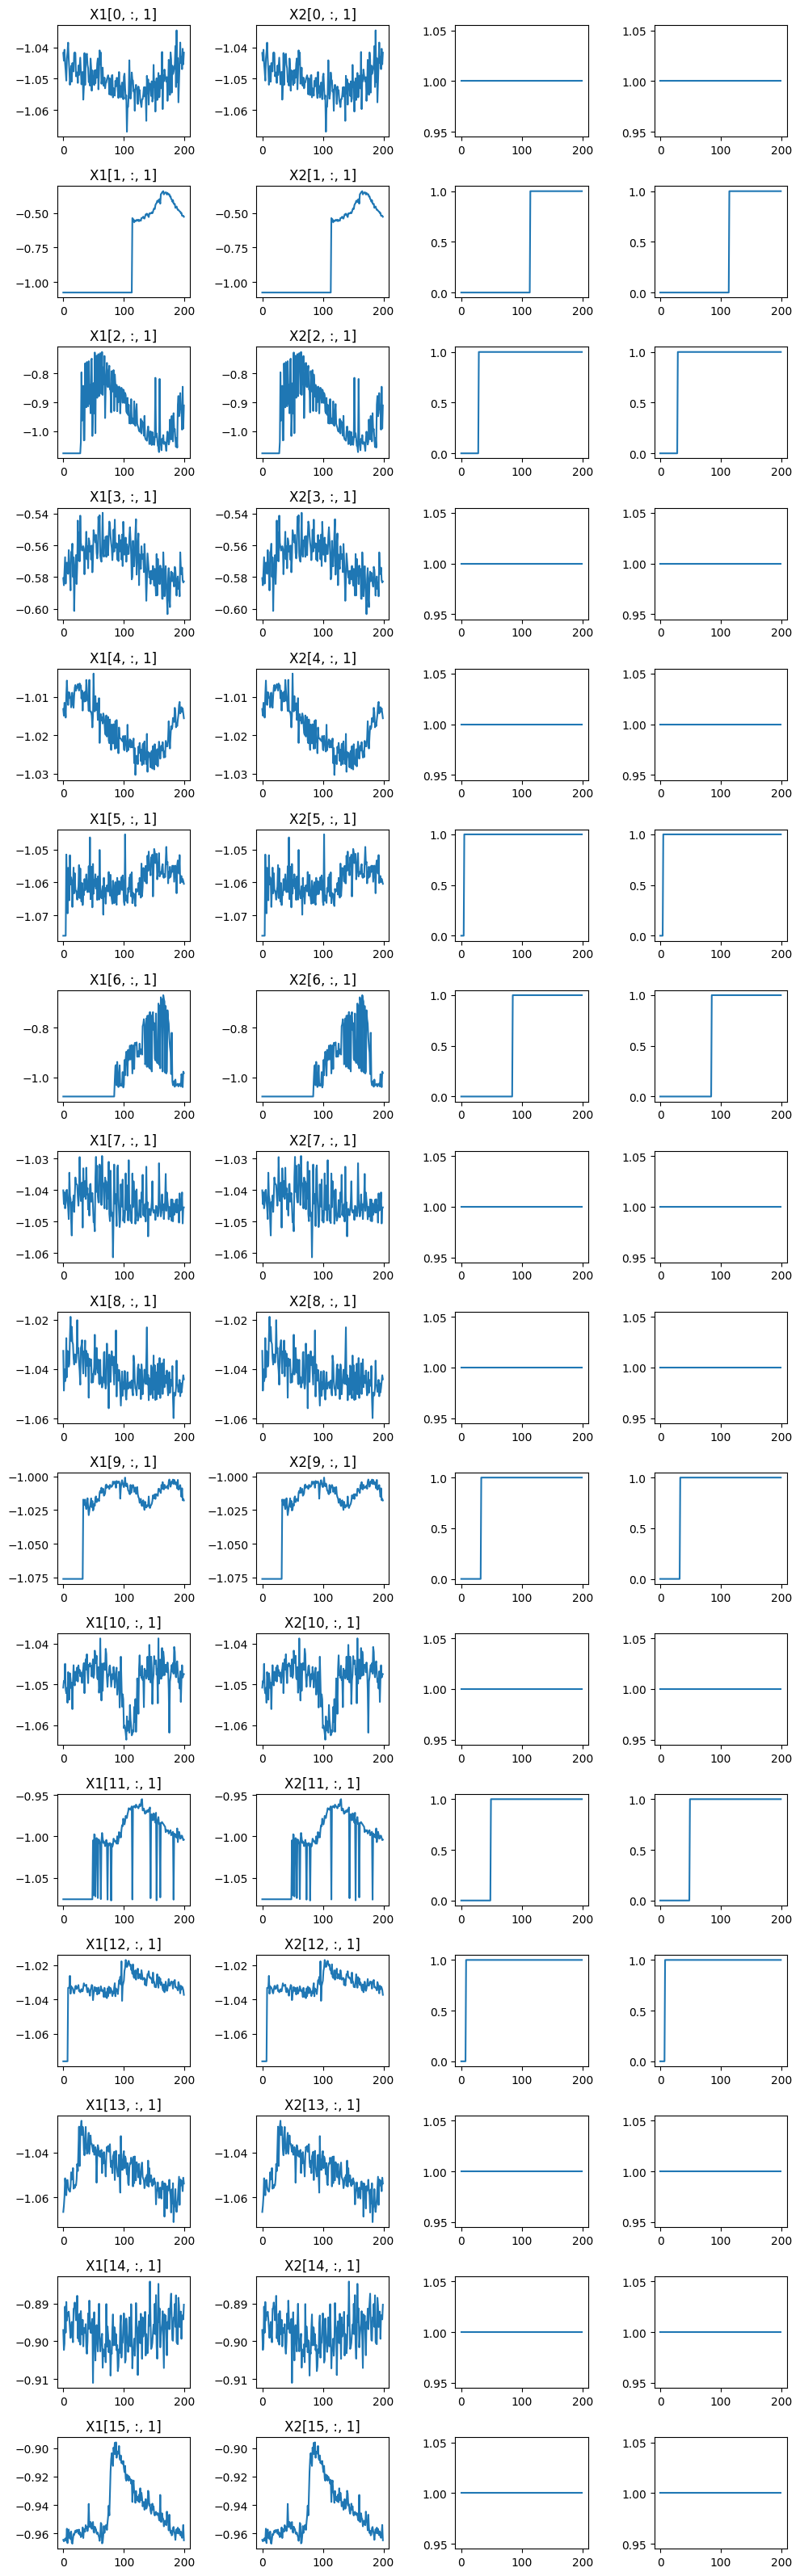

In [331]:
num_plots = X1.shape[0]
fig, axes = plt.subplots(num_plots, 4, figsize=(10, num_plots * 2))

for i in range(num_plots):
    axes[i, 0].plot(X1[i, :, 1])
    axes[i, 0].set_title(f'X1[{i}, :, 1]')
    
    axes[i, 1].plot(X2[i, :, 1])
    axes[i, 1].set_title(f'X2[{i}, :, 1]')

    axes[i, 2].plot(mask1[i])
    axes[i, 3].plot(mask2[i])
    
plt.tight_layout()
plt.show()

In [192]:
ds1.df = ds1.df.reset_index(drop=True)

In [195]:
ds1.df[ds1.df['edr3_source_id'].isin(inds)].index

Index([0, 1, 4, 12, 13, 15, 16, 18, 19, 22], dtype='int64')

In [169]:
len(ds1.df), len(ds2.df)

(154604, 154604)

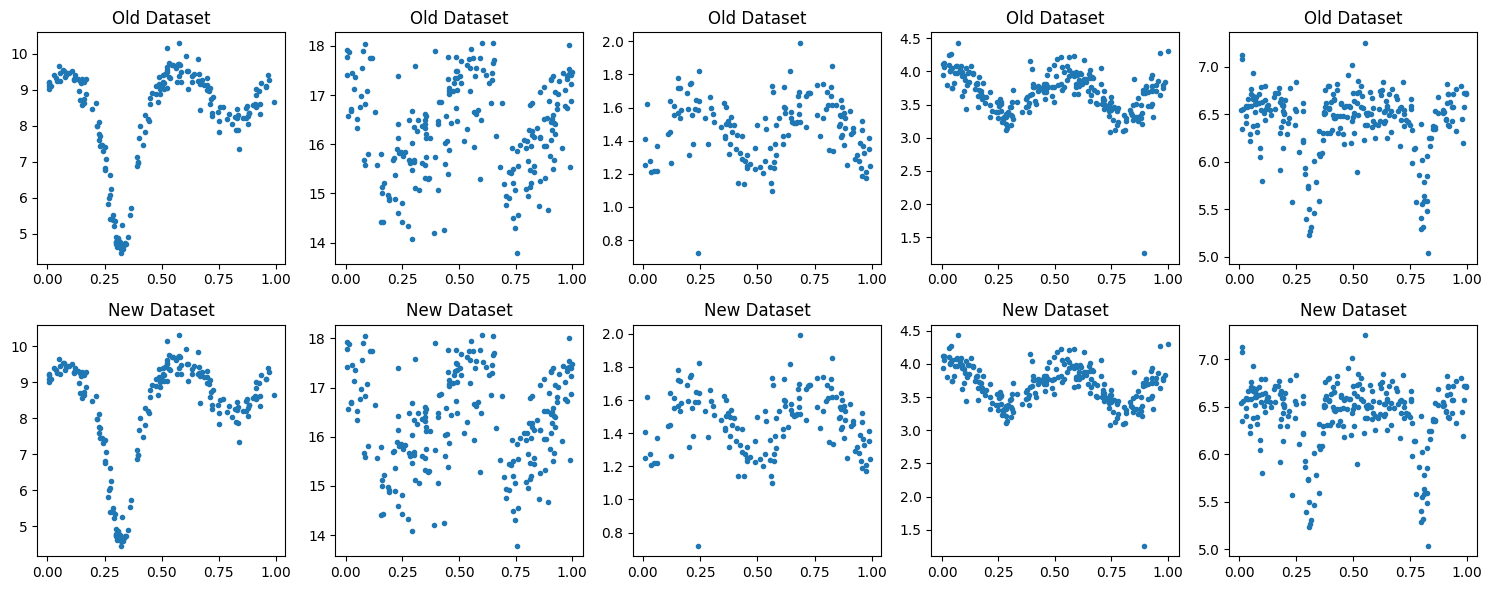

In [211]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images
source_ids = list(ds1.df[ds1.df['edr3_source_id'].isin(ds2.df['id'])]['edr3_source_id'])

for i in range(5):
    source_id = source_ids[i]
    lc1 = ds1[ds1.df[ds1.df['edr3_source_id'] == source_id].index[0]]['lcs'][0][0]
    lc2, _, _ = ds2[ds2.df[ds2.df['id'] == source_id].index[0]]
    
    axs[0, i].plot(lc1[:, 0], lc1[:, 1], '.')
    axs[1, i].plot(lc2[:, 0], lc2[:, 1], '.')

    axs[0, i].set_title('Old Dataset')
    axs[1, i].set_title('New Dataset')
    
plt.tight_layout()
plt.show()

In [74]:
lc1 = ds1.get_light_curves(ds1.df[ds1.df['edr3_source_id'] == 'EDR3 3526846175029144576'])

In [80]:
lc2, mask, y = ds2[730]

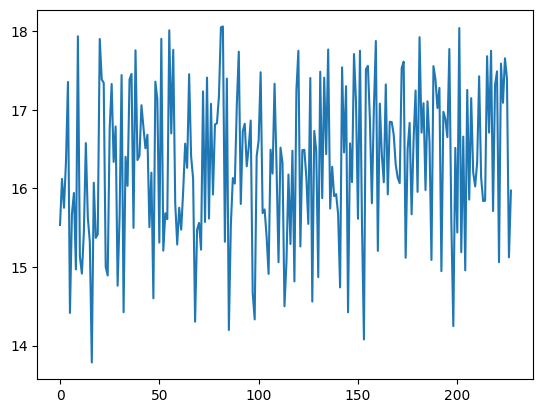

In [81]:
plt.plot(lc1[0][0][:, 1])

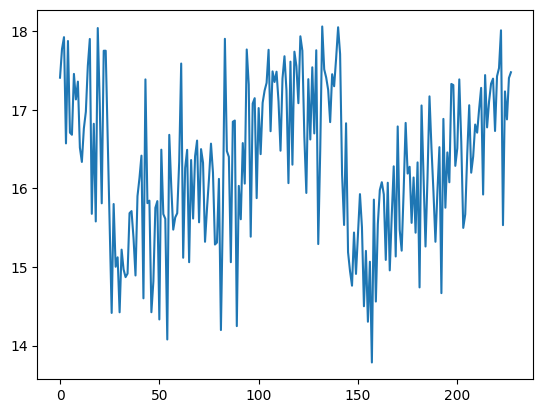

In [84]:
plt.plot(lc2[:, 0])

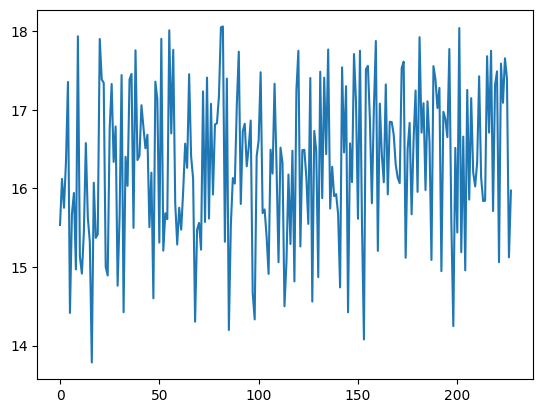

In [76]:
plt.plot(lc1[0][0][:, 1])

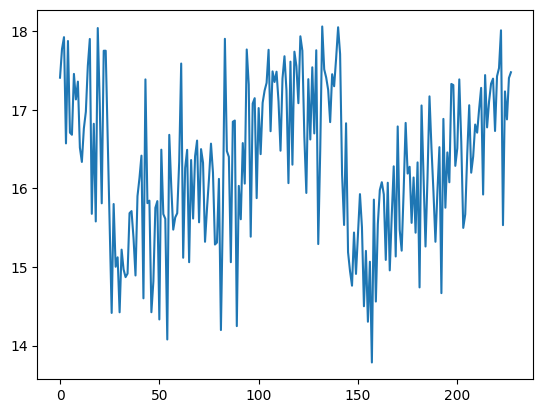

In [77]:
plt.plot(lc2[:, 0])